The IPSuite package is designed to build computational workflows which are executed at a later time.
Whilst this becomes extremly helpful, it is always a good start to learn the package in `eager` or direkt mode.
Some Nodes might produce outputs files, so please be aware that your workspace might be affected.

In [1]:
import os  # environment variables for GAP Model
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [2]:
import ipsuite as ips

/data/fzills/miniconda3/envs/ipsuite/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-03-09 16:09:50.744454: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-09 16:09:50.820438: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-09 16:09:51.410546: W tensorflow/compiler/xla/stream_executor/platform/defau

2023-03-09 16:09:52,627 (DEBUG): Welcome to IPS - the Interatomic Potential Suite!


In [3]:
with ips.Project() as project:
    data = ips.AddData(file="KCl1650K.extxyz", lines_to_read=100)
    random_selection = ips.configuration_selection.RandomSelection(
        data=data, n_configurations=5
    )
    uniform_selection = ips.configuration_selection.UniformEnergeticSelection(
        data=data, n_configurations=10, exclude_configurations=random_selection.exclude_configurations
    )
project.run(eager=True, save=False)


2023-03-09 16:09:52,748 (WARNING): Please run 'dvc add KCl1650K.extxyz' to track the file with DVC. Otherwise, it might end up being git tracked.


Reading File: 100it [00:00, 438.78it/s]


2023-03-09 16:09:52,989 (WARNING): Running search for 10 to max 100


In [4]:
random_selection.selected_configurations

{0: [35, 40, 61, 81, 98]}

In [5]:
uniform_selection.selected_configurations

{0: [0, 12, 18, 22, 26, 30, 34, 38, 44, 99]}

We can now train a GAP model on the given data.

Reading File: 100it [00:00, 445.91it/s]


2023-03-09 16:09:54,012 (WARNING): Running search for 10 to max 100
2023-03-09 16:09:54,087 (INFO): ---- Writing the GAP input file ----


/data/fzills/miniconda3/envs/ipsuite/lib/python3.10/site-packages/ase/io/extxyz.py:1000: UserWarning: write_xyz() overwriting array "forces" present in atoms.arrays with stored results from calculator
  warnings.warn('write_xyz() overwriting array "{0}" present '


2023-03-09 16:09:54,091 (INFO): --- Training model ---


100%|█████████████████████████████████| 10/10 [00:01<00:00,  9.53it/s]


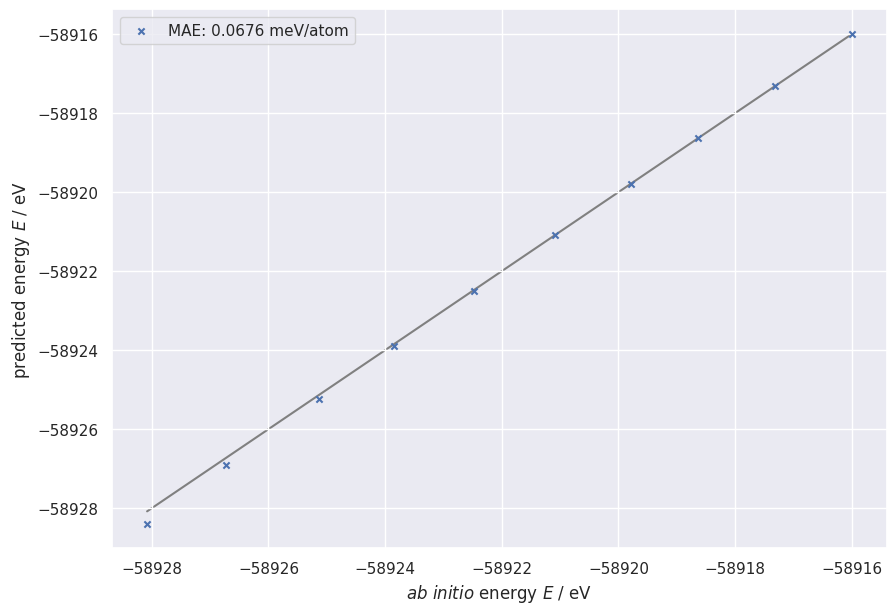

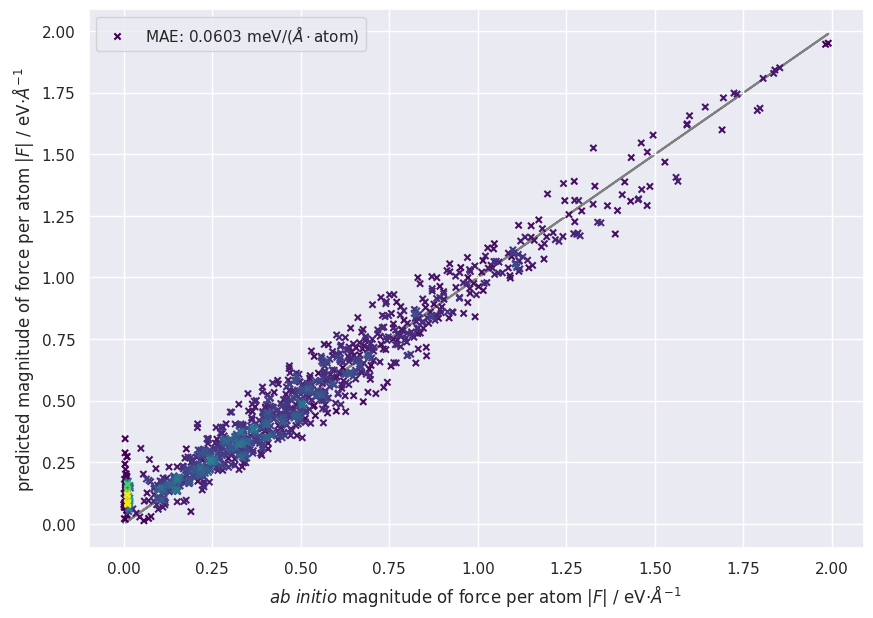

In [6]:
with project:
    model = ips.models.GAP(train_data=random_selection)
    prediction = ips.analysis.PredictWithModel(model=model, atoms=uniform_selection)
    analyse = ips.analysis.AnalysePrediction(prediction=prediction)
project.run(eager=True, save=False)

In the next Tutorial you will learn how to use DVC to track your Experiments and save the results.